# Text classification (multiclass) 


Classify consumer complaints into predefined categories.<br><br>
Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.<br><br>

### Importing packages and loading data

In [1]:
# Input data files are available in the "../input/" directory.
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# loading data
df = pd.read_csv('rows.csv')
df.shape

C:\Users\Harshit\AppData\Local\Temp/ipykernel_13092/1747995769.py:2: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('rows.csv')


(1282355, 18)

In [3]:
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282350,12/01/2011,Credit card,NaN,Credit determination,NaN,NaN,NaN,"CITIBANK, N.A.",MO,63301,NaN,NaN,Web,12/02/2011,Closed with relief,Yes,No,2396
1282351,12/01/2011,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",OH,45248,NaN,NaN,Web,12/06/2011,Closed without relief,No,No,2323
1282352,12/01/2011,Credit card,NaN,Billing disputes,NaN,NaN,NaN,JPMORGAN CHASE & CO.,OH,43207,NaN,NaN,Referral,12/01/2011,Closed with relief,Yes,No,2126
1282353,12/01/2011,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CO,80920,NaN,NaN,Web,12/01/2011,Closed with relief,Yes,No,2315


We have more than 1 million instances (rows) and 18 features (columns).


### Exploratory Data Analysis (EDA) and Feature Engineering

In [4]:
# Create a new dataframe with two columns to classify product and consumer complaint
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(383564, 2)

around 30% of the total dataset have consumer complaint, we will use this  non null data to classify the complaints. now lets look at the different categories to classify.

In [5]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

there are 18 categories but some of them are similar, so will have to preprocess and rename them before traning a model on this data.

In [6]:
# Renaming categories
df1.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfer': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [7]:
# new unique labels
df1['Product'].unique()

array(['Credit reporting, repair, or other', 'Debt collection',
       'Student loan', 'Mortgage', 'Credit card or prepaid card',
       'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Vehicle loan or lease',
       'Payday loan, title loan, or personal loan',
       'Bank account or service', 'Consumer Loan', 'Money transfers',
       'Other financial service'], dtype=object)

Encoding the Products before training the model

In [8]:
label_encoder = LabelEncoder()
df1['category_id'] = label_encoder.fit_transform(df1['Product'])

In [9]:
      
category_id_df = df1[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)


Now lets do EDA to check overall trends for number of complaints

In [10]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

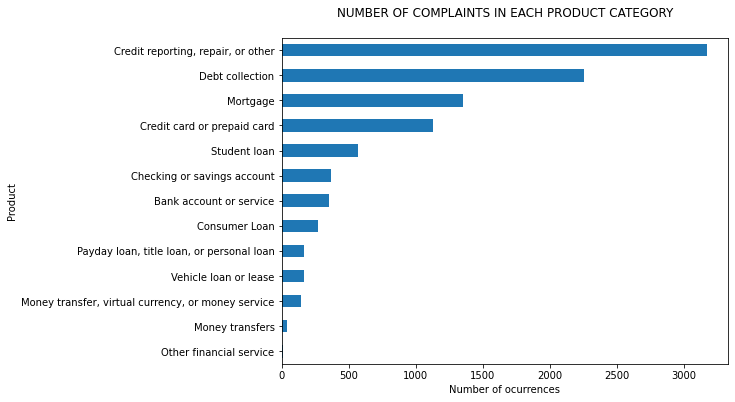

In [11]:
fig = plt.figure(figsize=(8,6))
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0,  title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

it is observed that most of the complaints are due to Credit Reporting, Debt Collection or Mortgage.

### Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

In [12]:
#text processing
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

In [13]:

print(features.shape)

(10000, 27507)


In [14]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, bank, scottrade
  * Most Correlated Bigrams are: citigold checking, debit card, checking account


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: checking, branch, overdraft
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: dealership, vehicle, car
  * Most Correlated Bigrams are: car loan, vehicle loan, regional acceptance


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, experian, equifax
  * Most Correlated Bigrams are: credit file, equifax xxxx, credit report


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, collect debt, collection agency


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: ethereum, bitcoin, coinbase
  * Most Correlated Bigrams are: account coinbase, coinbase xxxx, coinbase account


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: paypal, moneygram, gram
  * Most Correlated Bigrams are: sending money, western union, money gram


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: short sale, mortgage company, loan modification


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: meetings, productive, vast
  * Most Correlated Bigrams are: insurance check, check payable, face face


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: astra, ace, payday
  * Most Correlated Bigrams are: 00 loan, applied payday, payday loan


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: student, loans, navient
  * Most Correlated Bigrams are: income based, student loan, student loans

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: honda, car, vehicle
  * Most Correlated Bigrams are: used vehicle, total loss, honda financial


c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



### Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

In [24]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 3 Cross-validation
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/


### Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [25]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7784,0.002299
LogisticRegression,0.7575,0.004650
MultinomialNB,0.6318,0.004895
RandomForestClassifier,0.5180,0.004814


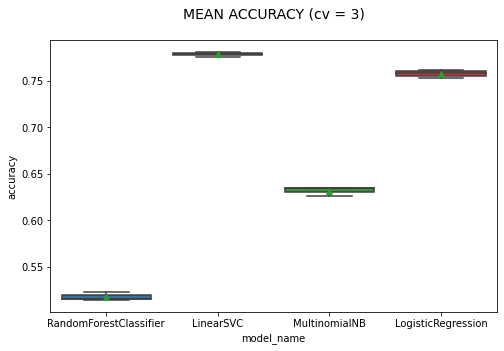

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',data=cv_df,showmeans=True)
plt.title("MEAN ACCURACY (cv = 3)\n", size=14);

### Model Evaluation

In [29]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df2.index, test_size=0.25, random_state=7)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# Classification report
print(metrics.classification_report(y_test, y_pred,target_names= df2['Product'].unique()))

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.64      0.38      0.47        93
                                   Debt collection       0.53      0.64      0.58        74
                                     Consumer Loan       0.53      0.28      0.37        67
                       Credit card or prepaid card       0.75      0.82      0.78       298
                                          Mortgage       0.80      0.86      0.83       817
                             Vehicle loan or lease       0.77      0.78      0.77       572
                                      Student loan       0.80      0.52      0.63        31
         Payday loan, title loan, or personal loan       0.57      0.31      0.40        13
                       Checking or savings account       0.87      0.93      0.90       320
                           Bank account or service       0.00      0.00      0.

c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

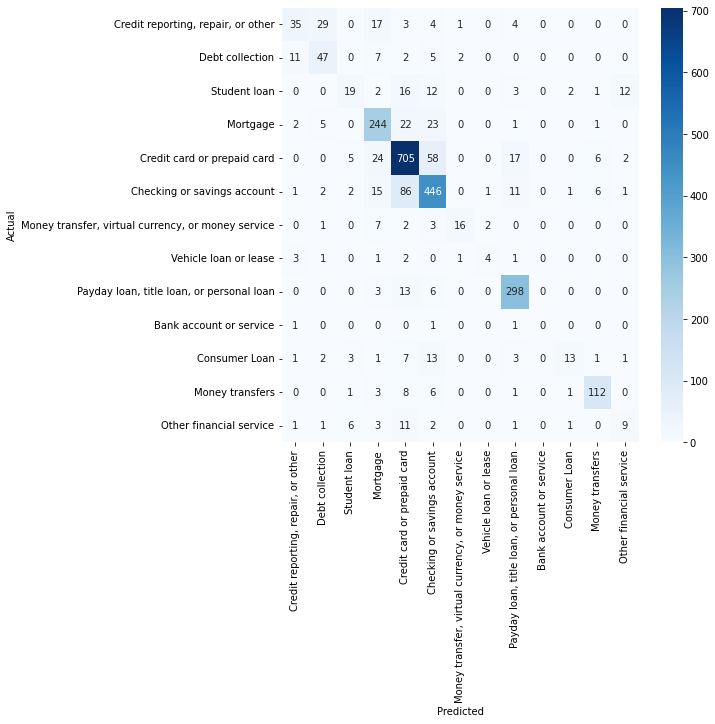

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted');

the confusion matrix and f1 score looks good for the cateogories for which we have good number of sample customer complaints. we can use this method and model to classify any Customer compalaint into any of these proudct category.